In [1]:
import os
import re
import string
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
import matplotlib.patches as mpatches
import seaborn as sns
from PIL import Image
from sklearn.cluster import DBSCAN
from astropy.io import fits
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap

In [2]:
#takes a minute
###----CHANGE THIS ONE---
parsed_file = pd.read_excel(r'C:/knime/cloudy_images.xlsx', index_col=0)  #path to parsed classifications file
users_removed = [] #what users should we remove?
parsed_file = parsed_file[~parsed_file['user_name'].isin(users_removed)]
parsed_file['ID'] = range(1, len(parsed_file)+1)
#orbit_list = [18211, 17959, 16570, 16750] #what orbits to process?

In [9]:
#orbit_list = [3486,6759, 15832, 15838, 18996, 18103, 18878, 19057, 17195, 16570, 19004, 17983, 17910, 18089, 19097, 17902, 17946, 18031, 18977, 16895, 17903, 17911, 17973, 18005, 18087, 18096, 19043, 17961, 17897, 18091, 16862, 17919, 18023, 16628, 17874, 17912, 17943]
orbit_list = [6628]

# Remove duplicates by converting to a set and back to a list
orbit_list = list(set(orbit_list))
logged_in_users = False #True for only logged in, False for all the users
base_path = r"C:\Users\lesze\orbitfolder\images"

<Figure size 1200x1015 with 0 Axes>

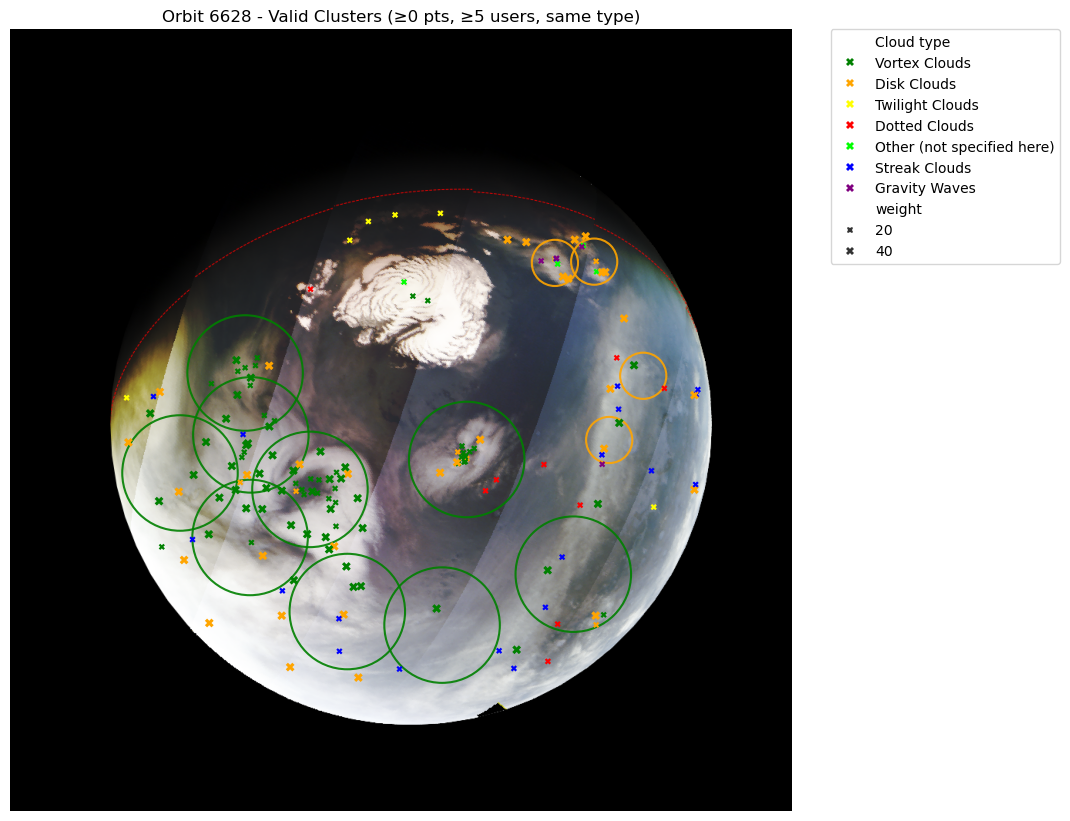

<Figure size 1200x1015 with 0 Axes>

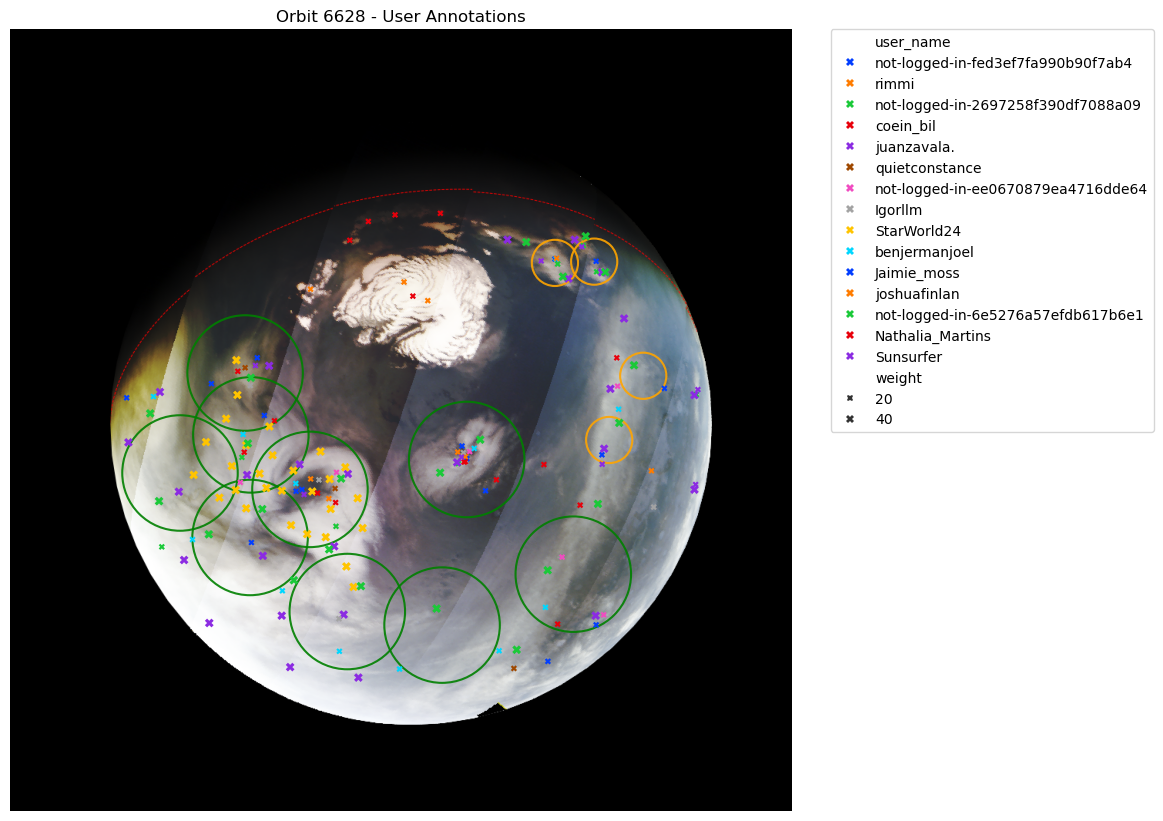

In [11]:
# Configuration parameters
MIN_POINTS = 0        # Minimum points required to form a cluster
MIN_UNIQUE_USERS = 5   # Minimum unique users required to form a cluster

# Complete color palette for all possible cloud types
CLOUD_PALETTE = {
    'Disk Clouds': 'orange',
    'Dotted Cloud': 'red',
    'Dotted Clouds': 'red',  # Alternate naming
    'Streak Cloud': 'blue',
    'Streak Clouds': 'blue', # Alternate naming
    'Vortex Clouds': 'green',
    'Twilight Clouds': 'yellow',
    'Gravity Waves': 'purple',
    'Other': 'lime',         # Default color
    'Other (not specified here)': 'lime'  # Handle this specific case
}
def get_cluster_annotations(points, cloud_types, weights, user_names):
    """Identify clusters where cloud type is determined by weighted majority of clicks."""
    if len(points) < MIN_POINTS:
        return [], []
    
    X = np.array(points)
    cloud_types = np.array(cloud_types)
    weights = np.array(weights)
    user_names = np.array(user_names)
    
    radius_rules = {
        'Disk Clouds': 30,
        'Dotted Clouds': 30,
        'Dotted Cloud': 30,
        'Streak Clouds': 50,
        'Streak Cloud': 50,
        'Vortex Clouds': 50,
        'Twilight Clouds': 50,
        'Gravity Waves': 30
    }
    
    # Calculate individual radii based on each point's type
    point_radii = np.array([radius_rules.get(ctype.strip(), 30) * weights[i] 
                          for i, ctype in enumerate(cloud_types)])
    
    labels = np.full(len(X), -1)
    current_label = 0
    cluster_info = []
    
    for i in range(len(X)):
        if labels[i] != -1:
            continue
            
        distances = np.sqrt(np.sum((X - X[i])**2, axis=1))
        neighbors = np.where((distances <= point_radii[i]) & (labels == -1))[0]
        
        if len(neighbors) >= MIN_POINTS:
            unique_users = list(set(user_names[neighbors]))
            if len(unique_users) >= MIN_UNIQUE_USERS:
                # Calculate weighted votes for each cloud type
                weighted_votes = {}
                for idx in neighbors:
                    ctype = cloud_types[idx]
                    weight = weights[idx]
                    if ctype in weighted_votes:
                        weighted_votes[ctype] += weight
                    else:
                        weighted_votes[ctype] = weight
                
                if weighted_votes:
                    # Get the type with highest weighted votes
                    dominant_type = max(weighted_votes.items(), key=lambda x: x[1])[0]
                    total_weight = sum(weighted_votes.values())
                    confidence = weighted_votes[dominant_type] / total_weight
                    
                    # Calculate radius based on dominant type's rule
                    dominant_radius = radius_rules.get(dominant_type, 30)
                    cluster_radius = dominant_radius 
                    
                    labels[neighbors] = current_label
                    cluster_info.append((
                        current_label, 
                        X[neighbors], 
                        cluster_radius, 
                        dominant_type,
                        confidence  # Weighted confidence score
                    ))
                    current_label += 1
    
    annotations = []
    circles = []
    
    for label, cluster_points, radius, ctype, confidence in cluster_info:
        center = np.mean(cluster_points, axis=0)
        letter = string.ascii_uppercase[label % 26]
        color = CLOUD_PALETTE.get(ctype, CLOUD_PALETTE['Other'])
        
        # Add confidence to annotation text if you want to display it
        annotation_text = f"{letter}"  # Could add: \n{confidence:.0%}
        annotations.append((center[0], center[1], annotation_text, color))
        circles.append((center[0], center[1], radius))
    
    return annotations, circles    

def plot_user_names_on_orbit(parsed_file, orbit_no, logged_in_users, bg_img):
    fig = plt.figure(figsize=(12, 10.15), dpi=100)
    
    df = parsed_file.loc[parsed_file['subject_data.orbit'] == orbit_no]
    if logged_in_users:
        df = df[~df['user_name'].str.contains('not-logged-in')]
    cols = ['ID', 'user_name', 'annotations_1.value.x', 'annotations_1.value.y', 
            'annotations_1.value.tool_label', 'weight']
    df = df[cols][df[cols].notnull().all(1)]
    df['Cloud type'] = df['annotations_1.value.tool_label'].str.split('!').str[0].str.strip()
    df['annotations_1.value.y'] = 1015 - df['annotations_1.value.y']
    df['weight'] = pd.to_numeric(df['weight'])
    
    points = df[['annotations_1.value.x', 'annotations_1.value.y']].values
    cloud_types = df['Cloud type'].values
    weights = df['weight'].values
    user_names = df['user_name'].values
    
    cluster_annotations, cluster_circles = get_cluster_annotations(
        points, cloud_types, weights, user_names)
    
    plt.figure(figsize=(12, 10.15))
    plt.imshow(bg_img, extent=[0, 1015, 0, 1015])
    
    # Draw all qualifying cluster boundaries in white
    for x, y, radius in cluster_circles:
        # Find the corresponding color for this cluster
        cluster_color = 'white'  # Default color
        for ann_x, ann_y, letter, color in cluster_annotations:
            if np.isclose(ann_x, x) and np.isclose(ann_y, y):
                cluster_color = color
                break
                
        circle = Circle((x, y), radius, 
                       fill=False, 
                       edgecolor=cluster_color,
                       linestyle='-',
                       linewidth=1.5,
                       alpha=0.9)
        plt.gca().add_patch(circle)
    
    # Plot with weighted sizes
    sizes = df['weight'] * 20
    scatter = sns.scatterplot(
        data=df,
        x='annotations_1.value.x',
        y='annotations_1.value.y',
        hue='user_name',
        palette="bright",
        size=sizes,
        sizes=(min(sizes), max(sizes)),
        marker='X',
        edgecolor='none',
        legend=True
    )
    
    # Move legend to upper right corner
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.xlim(0, 1015)
    plt.ylim(0, 1015)
    plt.title(f'Orbit {orbit_no} - User Annotations')
    plt.axis('off')
    plt.savefig(f"images_output/orbit_no_{orbit_no}_user_names.png", dpi=100, bbox_inches='tight')
    plt.show()

def plot_cloud_types_on_orbit(parsed_file, orbit_no, logged_in_users, bg_img):
    fig = plt.figure(figsize=(12, 10.15), dpi=100)
    
    df = parsed_file.loc[parsed_file['subject_data.orbit'] == orbit_no]
    if logged_in_users:
        df = df[~df['user_name'].str.contains('not-logged-in')]
    cols = ['ID', 'user_name', 'annotations_1.value.x', 'annotations_1.value.y', 
            'annotations_1.value.tool_label', 'weight']
    df = df[cols][df[cols].notnull().all(1)]
    df['Cloud type'] = df['annotations_1.value.tool_label'].str.split('!').str[0].str.strip()
    df['annotations_1.value.y'] = 1015 - df['annotations_1.value.y']
    df['weight'] = pd.to_numeric(df['weight'])
    
    # Ensure all cloud types in the data have a defined color
    unique_types = df['Cloud type'].unique()
    for t in unique_types:
        if t not in CLOUD_PALETTE:
            print(f"Warning: Cloud type '{t}' not in color palette, using default")
    
    points = df[['annotations_1.value.x', 'annotations_1.value.y']].values
    cloud_types = df['Cloud type'].values
    weights = df['weight'].values
    user_names = df['user_name'].values
    
    cluster_annotations, cluster_circles = get_cluster_annotations(
        points, cloud_types, weights, user_names)
    
    plt.figure(figsize=(12, 10.15))
    plt.imshow(bg_img, extent=[0, 1015, 0, 1015])
    
    # Draw all qualifying cluster boundaries with their respective colors
    for x, y, radius in cluster_circles:
        # Find the corresponding color for this cluster
        cluster_color = 'white'  # Default color
        for ann_x, ann_y, letter, color in cluster_annotations:
            if np.isclose(ann_x, x) and np.isclose(ann_y, y):
                cluster_color = color
                break
                
        circle = Circle((x, y), radius, 
                       fill=False, 
                       edgecolor=cluster_color,
                       linestyle='-',
                       linewidth=1.5,
                       alpha=0.9)
        plt.gca().add_patch(circle)
    
    # Plot with weighted sizes
    sizes = df['weight'] * 20
    scatter = sns.scatterplot(
        data=df,
        x='annotations_1.value.x',
        y='annotations_1.value.y',
        hue='Cloud type',
        palette=CLOUD_PALETTE,
        size=sizes,
        sizes=(min(sizes), max(sizes)),
        marker='X',
        edgecolor='none',
        legend=True
    )
    
    # Move legend to upper right corner
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlim(0, 1015)
    plt.ylim(0, 1015)
    plt.title(f'Orbit {orbit_no} - Valid Clusters (≥{MIN_POINTS} pts, ≥{MIN_UNIQUE_USERS} users, same type)')
    plt.axis('off')
    plt.savefig(f"images_output/orbit_no_{orbit_no}_cloud_types.png", dpi=100, bbox_inches='tight')
    plt.show()

# Example usage:
for orbit_no in orbit_list:
    prefix = f'orbit{str(orbit_no).zfill(5)}'
    
    # Search for files that start with this prefix
    for filename in os.listdir(base_path):
        if filename.startswith(prefix):
            try:
                # Construct full file path
                file_path = os.path.join(base_path, filename)
                
                # Open the image file
                bg_img = Image.open(file_path)
                plot_cloud_types_on_orbit(parsed_file, orbit_no, logged_in_users, bg_img)
                plot_user_names_on_orbit(parsed_file, orbit_no, logged_in_users, bg_img)
                
            except Exception as e:
                print(f"Error opening {filename}: {e}")